In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import pandas as pd
from google.colab import files
#uploaded = files.upload()
import pandas as pd
from imblearn.over_sampling import SMOTE
from collections import Counter

df = pd.read_csv('/content/RAC_train.csv')
print(df.head())

X = df[['temperature','time','solvent1','solvent2','solvent3','additive','param1','param2','param3','param4','param5']]
y = df['additive_category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=64)

print(f"Original y_train distribution: {Counter(y_train)}")

smote1 = SMOTE(sampling_strategy={0: y_train.value_counts()[1]}, random_state=64)
X_train_resampled, y_train_resampled = smote1.fit_resample(X_train,y_train)
print(f"Resampled y_train distribution,{Counter(y_train_resampled)}")

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
print("Level of split:", X_train.shape[0] / (X_train.shape[0] + X_test.shape[0]))

   temperature  time  solvent1  solvent2  solvent3  additive    param1  \
0          140    48       679         0         0       284  0.189590   
1          100    48      6228      6342         0         0  0.054899   
2          160   120       702         0         0         0  0.191143   
3          100    72      6228         0         0         0  0.073993   
4          120    72     31374         0         0         0  0.210237   

     param2    param3    param4    param5  additive_category  Unnamed: 12  \
0  0.332505 -0.110283 -0.350300  0.586608                  2          NaN   
1  0.332505  0.389717 -0.020010 -0.059007                  1          NaN   
2  0.332505  0.889717  0.040564 -0.304783                  1          NaN   
3  0.332505 -0.110283 -0.089079  0.295377                  1          NaN   
4  0.332505  0.389717 -0.027583  0.044372                  1          NaN   

   Unnamed: 13  Unnamed: 14  Unnamed: 15  
0          NaN          NaN          NaN  
1     

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)

X_test_scaled = scaler.transform(X_test)
print(X_train_scaled.shape)

(733, 11)


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

#Creating the model
model = keras.Sequential([
    layers.Dense(2048, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    layers.Dropout(0.5),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(y_train.unique()), activation='softmax')
])

# Compiling the model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.00022),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Training the model with 85 epochs
checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train_scaled, y_train_resampled, epochs=30, batch_size=4, validation_split=0.2, callbacks=[checkpoint, early_stopping])

# Loading and evaluating the best model
best_model = keras.models.load_model('best_model.keras')
best_loss, best_accuracy = best_model.evaluate(X_test_scaled, y_test)
print("Best Model Test Loss:", best_loss)
print("Best Model Test Accuracy:", best_accuracy)


Epoch 1/55
147/147 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - accuracy: 0.4697 - loss: 1.0116 - val_accuracy: 0.8912 - val_loss: 0.3611
Epoch 2/55
147/147 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - accuracy: 0.7285 - loss: 0.6728 - val_accuracy: 0.8912 - val_loss: 0.3462
Epoch 3/55
147/147 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - accuracy: 0.7728 - loss: 0.6207 - val_accuracy: 0.9524 - val_loss: 0.2139
Epoch 4/55
147/147 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - accuracy: 0.7793 - loss: 0.5566 - val_accuracy: 0.9592 - val_loss: 0.2091
Epoch 5/55
147/147 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - accuracy: 0.7903 - loss: 0.5295 - val_accuracy: 0.8912 - val_loss: 0.3145
Epoch 6/55
147/147 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step - accuracy: 0.8061 - loss: 0.4731 - val_accuracy: 0.9252 - val_loss: 0.2332
Epoch 7/55
147/147 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step - accuracy: 0.8251 - loss: 0.4605 - val_accuracy: 0.9048 - val_loss: 0.2544
Epoch 8/55
147/147 ━━━━━━━━━━━━━━━━━━━━ 8s 55ms/step - accuracy: 0.7736 - loss: 0.5262 - va

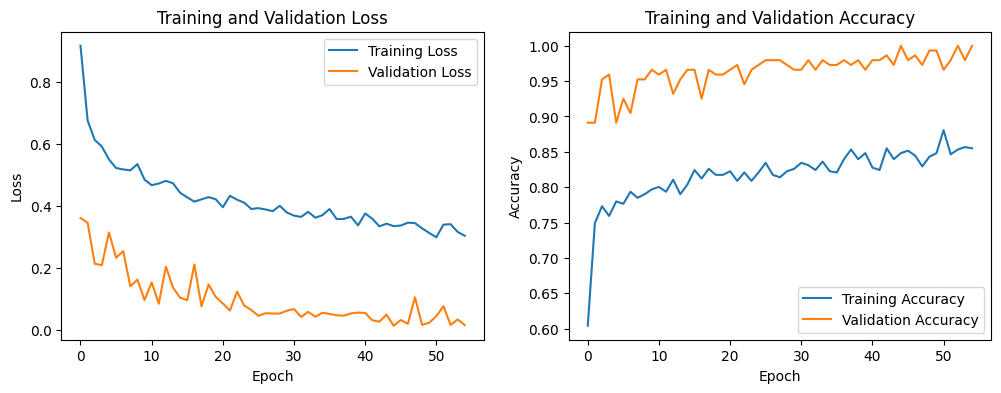

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Precision: 0.7573768823768824
Recall: 0.7592592592592593
F1-Score: 0.7567865136091257


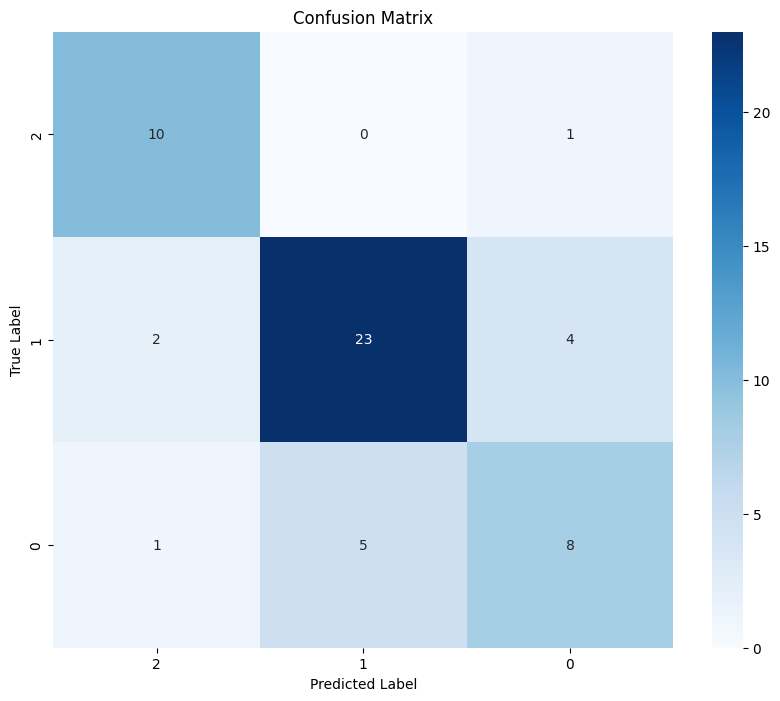

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

# Plotting training and validation loss against number of epochs
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

#Plotting the training and validation accuracy against number of epochs
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

# Making predictions on the test set
y_pred = best_model.predict(X_test_scaled)
y_pred_classes = y_pred.argmax(axis=1)

# Calculating precision, recall, and F1-score
precision = precision_score(y_test, y_pred_classes, average='weighted')
recall = recall_score(y_test, y_pred_classes, average='weighted')
f1 = f1_score(y_test, y_pred_classes, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

# Producing Confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Ploting the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=y_test.unique(), yticklabels=y_test.unique())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()